# Tiny Ray Tracer in xeus-cpp

An educational ray tracer based on Dmitry Sokolov’s “tinyraytracer” project

This notebook walks through the core ideas behind a minimal ray tracer, following the excellent educational series by Dmitry Sokolov (ssloy):

* GitHub project: https://github.com/ssloy/tinyraytracer  
* Tutorial series: https://github.com/ssloy/tinyraytracer/wiki

The tutorial builds a ray tracer step-by-step, starting from basic vector math and gradually introducing spheres, materials, shadows, reflections, refractions, and finally global illumination.

The implementation in this notebook corresponds to **Step 9** of the tutorial series, and can be extended further as an assignment toward **Step 10**, producing a more advanced final render.

In [1]:
#include <tuple>
#include <vector>
#include <algorithm>
#include <cmath>

// -------------------- Math & scene types --------------------

struct vec3 {
    float x = 0, y = 0, z = 0;

    float& operator[](const int i)       { return i==0 ? x : (1==i ? y : z); }
    const float& operator[](const int i) const { return i==0 ? x : (1==i ? y : z); }

    vec3  operator*(const float v) const { return {x*v, y*v, z*v};       }
    float operator*(const vec3& v) const { return x*v.x + y*v.y + z*v.z; }
    vec3  operator+(const vec3& v) const { return {x+v.x, y+v.y, z+v.z}; }
    vec3  operator-(const vec3& v) const { return {x-v.x, y-v.y, z-v.z}; }
    vec3  operator-()              const { return {-x, -y, -z};          }

    float norm() const { return std::sqrt(x*x + y*y + z*z); }
    vec3  normalized() const { return (*this) * (1.f / norm()); }
};

vec3 cross(const vec3 v1, const vec3 v2) {
    return {
        v1.y*v2.z - v1.z*v2.y,
        v1.z*v2.x - v1.x*v2.z,
        v1.x*v2.y - v1.y*v2.x
    };
}

struct Material {
    float refractive_index = 1.f;
    float albedo[4] = {2.f, 0.f, 0.f, 0.f};
    vec3  diffuse_color = {0.f, 0.f, 0.f};
    float specular_exponent = 0.f;
};

struct Sphere {
    vec3 center;
    float radius;
    Material material;
};

// -------------------- Scene definition --------------------

constexpr Material      ivory = {1.0f, {0.9f,  0.5f, 0.1f, 0.0f}, {0.4f, 0.4f, 0.3f},   50.f};
constexpr Material      glass = {1.5f, {0.0f,  0.9f, 0.1f, 0.8f}, {0.6f, 0.7f, 0.8f},  125.f};
constexpr Material red_rubber = {1.0f, {1.4f,  0.3f, 0.0f, 0.0f}, {0.3f, 0.1f, 0.1f},   10.f};
constexpr Material     mirror = {1.0f, {0.0f, 16.0f, 0.8f, 0.0f}, {1.0f, 1.0f, 1.0f}, 1425.f};

constexpr Sphere spheres[] = {
    {{-3.f,    0.f,   -16.f}, 2.f,      ivory},
    {{-1.0f, -1.5f,  -12.f}, 2.f,      glass},
    {{ 1.5f, -0.5f,  -18.f}, 3.f, red_rubber},
    {{ 7.f,   5.f,   -18.f}, 4.f,     mirror}
};

constexpr vec3 lights[] = {
    {-20.f, 20.f,  20.f},
    { 30.f, 50.f, -25.f},
    { 30.f, 20.f,  30.f}
};

// -------------------- Ray / intersection helpers --------------------

vec3 reflect(const vec3 &I, const vec3 &N) {
    return I - N * (2.f * (I * N));
}

vec3 refract(const vec3 &I, const vec3 &N, const float eta_t, const float eta_i = 1.f) {
    float cosi = - std::max(-1.f, std::min(1.f, I * N));
    if (cosi < 0.f)
        return refract(I, -N, eta_i, eta_t);

    float eta = eta_i / eta_t;
    float k = 1.f - eta*eta*(1.f - cosi*cosi);
    if (k < 0.f) {
        return {1.f, 0.f, 0.f}; // same hack as original code
    }
    return I*eta + N*(eta*cosi - std::sqrt(k));
}

std::tuple<bool, float> ray_sphere_intersect(const vec3 &orig, const vec3 &dir, const Sphere &s) {
    vec3 L = s.center - orig;
    float tca = L * dir;
    float d2  = L * L - tca*tca;
    float r2  = s.radius * s.radius;
    if (d2 > r2) return {false, 0.f};
    float thc = std::sqrt(r2 - d2);
    float t0 = tca - thc;
    float t1 = tca + thc;
    if (t0 > 0.001f) return {true, t0};
    if (t1 > 0.001f) return {true, t1};
    return {false, 0.f};
}

std::tuple<bool, vec3, vec3, Material> scene_intersect(const vec3 &orig, const vec3 &dir) {
    vec3 pt, N;
    Material material;

    float nearest_dist = 1e10f;

    // Checkerboard plane y = -4
    if (std::abs(dir.y) > 0.001f) {
        float d = -(orig.y + 4.f) / dir.y;
        vec3 p = orig + dir * d;
        if (d > 0.001f && d < nearest_dist && std::abs(p.x) < 10.f && p.z < -10.f && p.z > -30.f) {
            nearest_dist = d;
            pt = p;
            N  = {0.f, 1.f, 0.f};
            material.diffuse_color =
                ( (int(0.5f*pt.x + 1000.f) + int(0.5f*pt.z)) & 1 )
                ? vec3{0.3f, 0.3f, 0.3f}
                : vec3{0.3f, 0.2f, 0.1f};
        }
    }

    for (const Sphere &s : spheres) {
        auto [intersection, d] = ray_sphere_intersect(orig, dir, s);
        if (!intersection || d > nearest_dist)
            continue;
        nearest_dist = d;
        pt = orig + dir * nearest_dist;
        N  = (pt - s.center).normalized();
        material = s.material;
    }

    return {nearest_dist < 1000.f, pt, N, material};
}

vec3 cast_ray(const vec3 &orig, const vec3 &dir, const int depth = 0) {
    auto [hit, point, N, material] = scene_intersect(orig, dir);
    if (depth > 4 || !hit)
        return {0.2f, 0.7f, 0.8f};

    vec3 reflect_dir   = reflect(dir, N).normalized();
    vec3 refract_dir   = refract(dir, N, material.refractive_index).normalized();
    vec3 reflect_color = cast_ray(point, reflect_dir,  depth + 1);
    vec3 refract_color = cast_ray(point, refract_dir,  depth + 1);

    float diffuse_light_intensity  = 0.f;
    float specular_light_intensity = 0.f;

    for (const vec3 &light : lights) {
        vec3 light_dir = (light - point).normalized();
        auto [shadow_hit, shadow_pt, trashnrm, trashmat] = scene_intersect(point, light_dir);
        if (shadow_hit && (shadow_pt - point).norm() < (light - point).norm())
            continue;

        diffuse_light_intensity  += std::max(0.f, light_dir * N);
        specular_light_intensity += std::pow(std::max(0.f, -reflect(-light_dir, N) * dir),
                                             material.specular_exponent);
    }

    vec3 diffuse  = material.diffuse_color * (diffuse_light_intensity * material.albedo[0]);
    vec3 specular = vec3{1.f, 1.f, 1.f} * (specular_light_intensity * material.albedo[1]);
    vec3 reflectc = reflect_color * material.albedo[2];
    vec3 refractc = refract_color * material.albedo[3];

    return diffuse + specular + reflectc + refractc;
}

// -------------------- Render into framebuffer (no I/O) --------------------

constexpr int   IMAGE_WIDTH  = 1024;
constexpr int   IMAGE_HEIGHT = 768;
constexpr float FOV          = 1.05f; // ~60° in radians

std::vector<vec3> render_frame()
{
    std::vector<vec3> framebuffer(IMAGE_WIDTH * IMAGE_HEIGHT);

    for (int pix = 0; pix < IMAGE_WIDTH * IMAGE_HEIGHT; ++pix) {
        float dir_x =  (pix % IMAGE_WIDTH  + 0.5f) -  IMAGE_WIDTH  / 2.f;
        float dir_y = -(pix / IMAGE_WIDTH  + 0.5f) +  IMAGE_HEIGHT / 2.f;
        float dir_z = -IMAGE_HEIGHT / (2.f * std::tan(FOV / 2.f));

        vec3 dir = vec3{dir_x, dir_y, dir_z}.normalized();
        framebuffer[pix] = cast_ray(vec3{0.f, 0.f, 0.f}, dir);
    }

    return framebuffer;
}


In [2]:
#include <string>
#include <fstream>
#include <sstream>
#include <vector>
#include <cstdint>
#include <iostream>

#include "nlohmann/json.hpp"
#include "xeus/xbase64.hpp"
#include "xcpp/xdisplay.hpp"

namespace nl = nlohmann;

// ---------- Jupyter display helper: BMP file -> notebook ----------

namespace im
{
    struct image
    {
        explicit image(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);
            m_buffer << fin.rdbuf();
        }
        std::stringstream m_buffer;
    };

    nl::json mime_bundle_repr(const image& i)
    {
        nl::json bundle = nl::json::object();
        bundle["image/bmp"] = xeus::base64encode(i.m_buffer.str());
        return bundle;
    }
}

void display_bmp_in_notebook(const std::string& filename)
{
    im::image img(filename);
    xcpp::display(img);
}

// ---------- Minimal 24-bit BMP writer ----------

void write_bmp(const std::string& filename, const std::vector<vec3>& framebuffer)
{
    if (framebuffer.size() != static_cast<std::size_t>(IMAGE_WIDTH * IMAGE_HEIGHT)) {
        std::cerr << "[ERROR] framebuffer size mismatch\n";
        return;
    }

    const int width  = IMAGE_WIDTH;
    const int height = IMAGE_HEIGHT;
    const int bytes_per_pixel = 3;           // 24-bit RGB
    const int row_stride       = width * bytes_per_pixel;
    const int padded_row_stride = (row_stride + 3) & ~3; // rows padded to multiple of 4 bytes

    const std::uint32_t file_size = 54 + padded_row_stride * height;

    unsigned char file_header[14] = {
        'B','M',                      // signature
        0,0,0,0,                      // file size
        0,0, 0,0,                     // reserved
        54,0,0,0                      // pixel data offset
    };

    unsigned char dib_header[40] = {
        40,0,0,0,                     // DIB header size
        0,0,0,0,                      // width
        0,0,0,0,                      // height
        1,0,                          // color planes
        24,0,                         // bits per pixel
        0,0,0,0,                      // compression (none)
        0,0,0,0,                      // image size (can be 0 for BI_RGB)
        0x13,0x0B,0,0,                // horizontal resolution (2835 px/m)
        0x13,0x0B,0,0,                // vertical resolution
        0,0,0,0,                      // colors in palette
        0,0,0,0                       // important colors
    };

    // fill file size
    file_header[ 2] = (unsigned char)( file_size        );
    file_header[ 3] = (unsigned char)( file_size >>  8 );
    file_header[ 4] = (unsigned char)( file_size >> 16 );
    file_header[ 5] = (unsigned char)( file_size >> 24 );

    // fill width & height
    int w = width;
    int h = height;
    dib_header[ 4] = (unsigned char)( w        );
    dib_header[ 5] = (unsigned char)( w >>  8 );
    dib_header[ 6] = (unsigned char)( w >> 16 );
    dib_header[ 7] = (unsigned char)( w >> 24 );

    dib_header[ 8] = (unsigned char)( h        );
    dib_header[ 9] = (unsigned char)( h >>  8 );
    dib_header[10] = (unsigned char)( h >> 16 );
    dib_header[11] = (unsigned char)( h >> 24 );

    std::ofstream out(filename, std::ios::binary);
    if (!out) {
        std::cerr << "[ERROR] cannot open " << filename << " for writing\n";
        return;
    }

    out.write(reinterpret_cast<char*>(file_header), sizeof(file_header));
    out.write(reinterpret_cast<char*>(dib_header),  sizeof(dib_header));

    std::vector<unsigned char> row(padded_row_stride);

    // BMP stores rows bottom-up
    for (int y = 0; y < height; ++y) {
        int by = height - 1 - y; // flip vertically
        for (int x = 0; x < width; ++x) {
            const vec3& c = framebuffer[by * width + x];

            float maxc = std::max(1.f, std::max(c[0], std::max(c[1], c[2])));
            unsigned char r = static_cast<unsigned char>(255.f * c[0] / maxc);
            unsigned char g = static_cast<unsigned char>(255.f * c[1] / maxc);
            unsigned char b = static_cast<unsigned char>(255.f * c[2] / maxc);

            // BMP is BGR
            int idx = x * 3;
            row[idx + 0] = b;
            row[idx + 1] = g;
            row[idx + 2] = r;
        }
        // zero padding already in vector's default-initialized bytes
        out.write(reinterpret_cast<char*>(row.data()), padded_row_stride);
    }
}

// ---------- Glue: framebuffer -> BMP -> notebook ----------

void display_framebuffer_as_bmp(const std::vector<vec3>& framebuffer,
                                const std::string& filename = "raytrace.bmp")
{
    write_bmp(filename, framebuffer);
    display_bmp_in_notebook(filename);
    std::remove(filename.c_str());
}

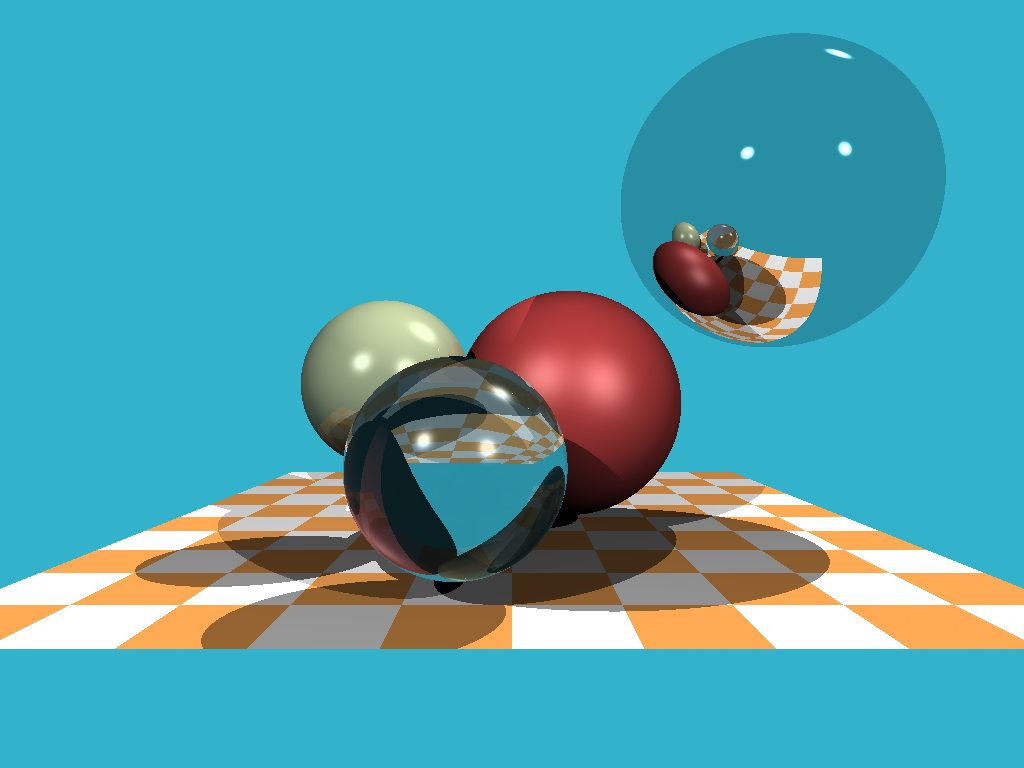

In [3]:
auto fb = render_frame();
display_framebuffer_as_bmp(fb);